In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
# univariate multi-step lstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import ConvLSTM2D
#from keras.layers.convolutional_recurrent import ConvGRU2D
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam #RMSProp
from tensorflow.keras.utils import plot_model
import pydot

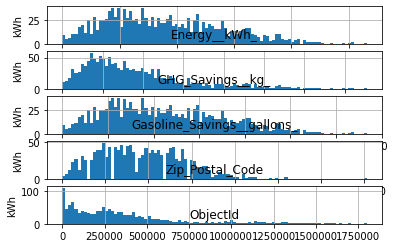

In [2]:
# histogram plots
from pandas import read_csv
from matplotlib import pyplot
# load the new file
#dataset = read_csv('modelData_season_hourly.csv', header=0, infer_datetime_format=True, parse_dates=['Date'], index_col=['Date'])
#dataset = read_csv('AGG_EVCS.csv', header=0, infer_datetime_format=True)#, parse_dates=['Start Date'], index_col=['Start Date'])
#dataset = read_csv('EV_household_data_D.csv', header=0, infer_datetime_format=True, parse_dates=['Date'], index_col=['Date'])
dataset = read_csv('Bevse_D.csv', header=0, infer_datetime_format=True, parse_dates=['Start Date'], index_col=['Start Date'])

#dataset = read_csv('household_power_consumption_hourly.csv', header=0, infer_datetime_format=True, parse_dates=['Date Time'], index_col=['Date Time'])


# histogram plot for each variable
pyplot.figure()
for i in range(len(dataset.columns)):
	pyplot.subplot(len(dataset.columns), 1, i+1)
	name = dataset.columns[i]
	dataset[name].hist(bins=100)
#	pyplot.bar(BRYANT #1 (kWh))    
	pyplot.title(name, y=0)
	plt.ylabel('kWh')    
pyplot.show()

In [3]:
dataset.head

<bound method NDFrame.head of             Energy__kWh_  GHG_Savings__kg_  Gasoline_Savings__gallons_  \
Start Date                                                               
2018-01-02        17.527             7.361                       2.199   
2018-01-03        11.227             4.716                       1.409   
2018-01-04        49.748            20.895                       6.244   
2018-01-05         2.956             1.241                       0.371   
2018-01-06        32.720            13.742                       4.106   
...                  ...               ...                         ...   
2021-11-25       123.851            87.935                      15.544   
2021-11-26       271.067           192.458                      34.020   
2021-11-27       203.999           144.837                      25.599   
2021-11-28       275.529           195.626                      34.578   
2021-11-29       280.653           199.263                      35.224   

       

In [4]:
# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
    
#	n = len(data)
#	train = data[0:int(n*0.9)]
#	val_df = data[int(n*0.7):int(n*0.9)]
#	test = data[int(n*0.9):]    

	train, test = dataset[32:24392], dataset[24392:34472]
	train = array(split(train, len(train)/(7*24)))
#print([samples(weeks), timesteps(hours), features], {}.format(train.shape))
	test = array(split(test, len(test)/(7*24)))
#print([samples(weeks), timestemps(hours), features], {}.format(test.shape))
	return train, test
#	train, test = data[1:-328], data[-328:-6]
    
	# restructure into windows of weekly data
#	train = array(split(train, len(train)/(7*24)))
#	test = array(split(test, len(test)/(7*24)))
#	return train, test
 

In [3]:
# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test
 
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# calculate mape
		mape = np.mean(np.abs((actual[:,i] - predicted[:,i]) / actual[:,i]))*100 
		mae = np.mean(np.abs((actual[:,i] - predicted[:,i])))
		# store
		scores.append(mape)#mape, mse, rmse
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = (s / (actual.shape[0] * actual.shape[1])) # #sqrt
	# plot the results
#	print(predicted)
#	print(actual)
	fig = plt.figure()
	pyplot.plot(actual[:,5], marker ='x', color ='green', label = 'actual')
	pyplot.plot(predicted[:,5], marker = 'o', label = 'predicted')
	pyplot.legend()    
	plt.xlabel('Time')
	plt.ylabel('Normalized Electricity load')
	pyplot.show()
	fig.savefig('output_load_forecasting.jpg', bbox_inches='tight')    
	return score, scores

In [4]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))
 
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)   #univariate 
#			X.append(data[in_start:in_end, :])   #multivariate change         
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [9]:
# train the model CONVLSTM-LSTM
def build_model(train, n_steps, n_length, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 1000, 64
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape into subsequences [samples, time steps, rows, cols, channels]
	train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model with 4 convlstm and 2 LSTM layers
	model = Sequential()
	model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features), return_sequences = True)) 
	model.add(BatchNormalization())
#	model.add((ConvLSTM2D(128, kernel_size = (1, 3), activation='relu', padding = 'same', return_sequences = True)))
#	model.add((ConvLSTM2D(64, kernel_size = (1, 3), activation='relu', padding = 'same', return_sequences = True)))
#	model.add((ConvLSTM2D(64, kernel_size = (1, 3), activation='relu', padding = 'same', return_sequences = True)))    
#	model.add(BatchNormalization())    
##	model.add(Bidirectional(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features), return_sequences = True)))
#	model.add(Bidirectional(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', return_sequences = True)))
#	model.add(BatchNormalization())    
	model.add(Flatten())

    
	model.add(RepeatVector(n_outputs))

    ####    *****DECODER*****#####    
	#lstm or Gru
### You can comment the decoder for the purpose of ablation study
#	model.add((Dense(100, activation='relu', return_sequences = True)))
#	model.add((LSTM(200, activation='relu',kernel_regularizer=regularizers.l2(0.001), return_sequences=True)))#     



##	model.add((LSTM(200, activation='relu',kernel_regularizer=regularizers.l2(0.01), return_sequences=True)))# 
##	model.add(Dropout(0.5))      
##	model.add((LSTM(200, activation='relu', kernel_regularizer=regularizers.l2(0.01),return_sequences=True))) # kernel_regularizer=regularizers.l2(0.001),   
##	model.add(Dropout(0.5))  
##	model.add((LSTM(200, activation='relu', return_sequences=True)))    
#	model.add((LSTM(200, activation='relu', return_sequences=True)))    
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	opt = tf.keras.optimizers.Adam(learning_rate = 0.01)
	model.compile(loss='mse', optimizer=opt)
	# fit network
	# fit network
	history = model.fit(train_x, train_y, epochs=epochs, validation_split=0.01,batch_size=batch_size, verbose=verbose)
	model.summary()
# Add title and axis names
	plt.title('ConvLSTM-LSTM')   
	pyplot.plot(history.history['loss'], label='train')
	pyplot.plot(history.history['val_loss'], label='val')
	pyplot.legend()
	plt.xlabel('Epochs')
	plt.ylabel('MSE')
	pyplot.show()      

	return model

In [10]:
# train the model CONVLSTM-BiLSTM
def build_model(train, n_steps, n_length, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 1000, 32
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape into subsequences [samples, time steps, rows, cols, channels]
	train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    
	# define model with 4 convlstm and 2 LSTM layers
	model = Sequential()
	model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features), return_sequences = True)) 
#	model.add(BatchNormalization())
#	model.add((ConvLSTM2D(64, kernel_size = (1, 3), activation='relu', padding = 'same', return_sequences = True)))
##	model.add((ConvLSTM2D(32, kernel_size = (1, 3), activation='relu', padding = 'same', return_sequences = True)))
##	model.add((ConvLSTM2D(16, kernel_size = (1, 3), activation='relu', padding = 'same', return_sequences = True)))    
#	model.add(BatchNormalization())    
#	model.add(Bidirectional(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features))))
#	model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='elu', return_sequences = False))
#	model.add(BatchNormalization())    
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))##
	model.add(Bidirectional(LSTM(200, activation='relu',kernel_regularizer=regularizers.l2(0.001), return_sequences=True)))#     
	model.add(Bidirectional(LSTM(200, activation='relu',kernel_regularizer=regularizers.l2(0.001), return_sequences=True)))# 
	model.add(Bidirectional(LSTM(200, activation='relu',kernel_regularizer=regularizers.l2(0.001), return_sequences=True)))
#	model.add(Dropout(0.5))      
##	model.add((LSTM(200, activation='relu', kernel_regularizer=regularizers.l2(0.001),return_sequences=True))) # kernel_regularizer=regularizers.l2(0.001),   
##	model.add(Dropout(0.5))  
#	model.add((LSTM(200, activation='relu', return_sequences=True)))    
#	model.add((LSTM(200, activation='relu', return_sequences=True)))    
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	# fit network
	history = model.fit(train_x, train_y, epochs=epochs, validation_split=0.01,batch_size=batch_size, verbose=verbose)
	model.summary()
	plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# Add title and axis names
	plt.title('CONVLSTM-BiLSTM')
	pyplot.plot(history.history['loss'], label='train')
	pyplot.plot(history.history['val_loss'], label='val')
	pyplot.legend()
	plt.xlim(0, 1000)
	plt.ylim(0, 1)      
	plt.xlabel('Epochs')
	plt.ylabel('MSE')
	pyplot.show()      

	return model

In [6]:
## conv-lstm
# make a forecast
def forecast(model, history, n_steps, n_length, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:,0]     # 0 for univariate and : fro mutivariate
	# reshape into [samples, time steps, rows, cols, channels]
	input_x = input_x.reshape((1, n_steps, 1, n_length, 1))
    
	# retrieve last observations for input data
#	input_x = data[-n_input:, :]
	# reshape into [1, n_input, n]
#	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))    
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [7]:
# evaluate a single model
def evaluate_model(train, test, n_steps, n_length, n_input):
	# fit model
	model = build_model(train, n_steps, n_length, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_steps, n_length, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_2 (ConvLSTM2D)  (None, 2, 1, 12, 64)      50176     
                                                                 
 batch_normalization_2 (Batc  (None, 2, 1, 12, 64)     256       
 hNormalization)                                                 
                                                                 
 flatten_2 (Flatten)         (None, 1536)              0         
                                                                 
 repeat_vector_2 (RepeatVect  (None, 7, 1536)          0         
 or)                                                             
                                                                 
 time_distributed_4 (TimeDis  (None, 7, 100)           153700    
 tributed)                                                       
                                                      

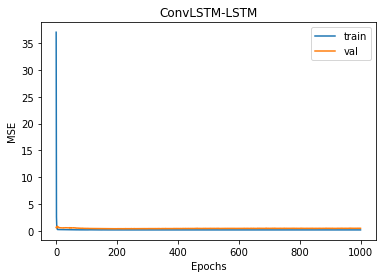

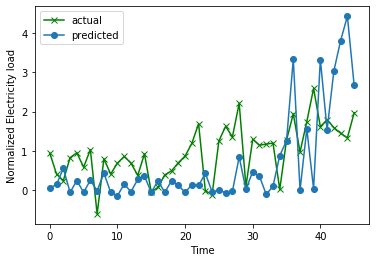

convlstm-lstm: [1.523] 374.9, 671.5, 267.1, 207.6, 336.3, 447.5, 918.0


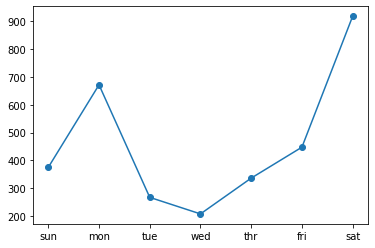

In [11]:
# load the new file
#dataset = read_csv('household_power_consumption_hourly.csv', header=0, infer_datetime_format=True, parse_dates=['Date Time'], index_col=['Date Time'])
#dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])

#dataset = read_csv('modelData_season_daily.csv', header=0, infer_datetime_format=True, parse_dates=['Date'], index_col=['Date'])
#dataset = read_csv('ISONE_daily.csv', header=0, infer_datetime_format=True, parse_dates=['date'], index_col=['date'])
#dataset = read_csv('EV_household_data_D.csv', header=0, infer_datetime_format=True, parse_dates=['Date'], index_col=['Date'])
dataset = read_csv('PAevse_D.csv', header=0, infer_datetime_format=True, parse_dates=['Start Date'], index_col=['Start Date'])
#  Devcs, Pthevcs, PAevse, Bevse, elaadevcs

#Standardize the dataset
data_mean = dataset[:].mean(axis=0)
data_std = dataset[:].std(axis=0)
dataset = (dataset-data_mean)/data_std

# split into train and test
train, test = split_dataset(dataset.values)
# define the number of subsequences and the length of subsequences
n_steps, n_length = 2,14
# define the total days to use as input
n_input = n_length* n_steps
score, scores = evaluate_model(train, test, n_steps, n_length, n_input)
# summarize scores
summarize_scores('convlstm-lstm', score, scores)

# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

## LSTM Model

-Define forecast function
-Evaluate model
-Data normlization, input sequence length selection, and function call

In [39]:
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 100, 64
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    
    
	model.summary() 
    
# Add title and axis names
	plt.title('LSTM') #GRU
	pyplot.plot(history.history['loss'], label='train')
	pyplot.plot(history.history['val_loss'], label='val')
	pyplot.legend()
	pyplot.xlabel('Epochs')
	pyplot.ylabel('MSE')
	pyplot.show()    
	return model

In [28]:
# Build and train the LSTM based models e.g. Sequential LSTM, GRU, etc.
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 100, 64
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features), return_sequences = True))
#	model.add(Bidirectional(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features))))    
#	model.add(GRU(100, activation='relu', input_shape=(n_timesteps, n_features), return_sequences = True))    
	model.add(Dropout(0.5))
#	model.add(GRU(100, activation='relu', return_sequences = False))
#	model.add(Dropout(0.5))
#	model.add(LSTM(200, activation='relu', return_sequences = False))    
#	model.add(Dropout(0.5))    
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, validation_split=0.3,batch_size=batch_size, verbose=verbose)
	model.summary() 
    
# Add title and axis names
	plt.title('LSTM') #GRU
	pyplot.plot(history.history['loss'], label='train')
	pyplot.plot(history.history['val_loss'], label='val')
	pyplot.legend()
	pyplot.xlabel('Epochs')
	pyplot.ylabel('MSE')
	pyplot.show()
	return model

In [40]:
# make a forecast using LSTM
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [41]:
# evaluate LSTM model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

In [21]:
#Training LSTM model
# load the new file
#dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
dataset = read_csv('modelData_season_daily.csv', header=0, infer_datetime_format=True, parse_dates=['Date'], index_col=['Date'])
#dataset = read_csv('ISONE_daily.csv', header=0, infer_datetime_format=True, parse_dates=['date'], index_col=['date'])
#dataset = read_csv('EV_household_data_D.csv', header=0, infer_datetime_format=True, parse_dates=['Date'], index_col=['Date'])

#Standardize the dataset
data_mean = dataset[:].mean(axis=0)
data_std = dataset[:].std(axis=0)
dataset = (dataset-data_mean)/data_std

# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 14
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

NameError: name 'train' is not defined